In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [2]:
if __name__ == "__main__":
    config = {}
    config["num_layers"] = 12
    config["hidden_dim"] = 256
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    
    # Hyperparameters
    config["image_size"] = 512
    config["patch_size"] = 32
    config["num_patches"] = int(config["image_size"]**2 / config["patch_size"]**2)
    config["num_channels"] = 3
    config["num_classes"] = 10

In [3]:
class classToken(Layer):
    def __init__(self):
        super().__init__()
    
    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape = (1,1, input_shape[-1]), dtype = tf.float32),
            trainable = True
        )
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]
        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype = inputs.dtype)
        return cls     

In [4]:
def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation = "gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

In [5]:
def transformer_encoder(x,cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads = cf["num_heads"], key_dim = cf["hidden_dim"]
        )(x,x)
    x = Add()([x, skip_1])
    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])
    return x

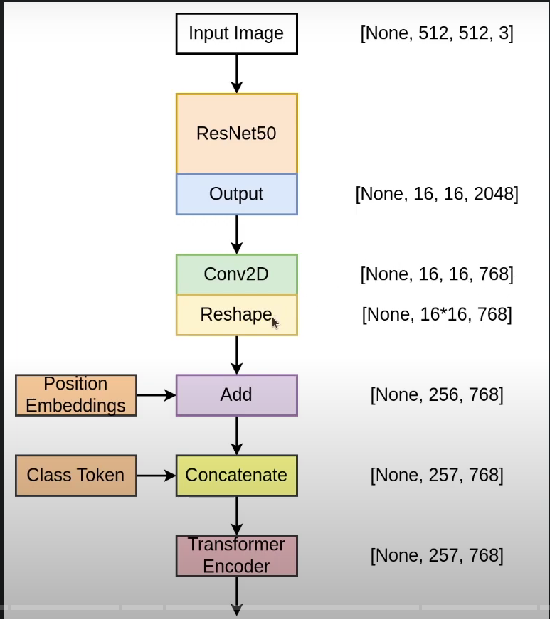

In [8]:
def ResNet50ViT(cf):
    
    """ Inputs """
    
    inputs = Input((cf["image_size"] , cf["image_size"], cf["num_channels"])) # (None, 512, 512, 3)
    
    """ Pre Trained ResNet50 """
    
    resnet50 = ResNet50( include_top = False, weights = "imagenet", input_tensor = inputs)
    
    output = resnet50.output # Output --> (None, 16, 16, 2048)
    
    """ Patch Embedding """
    
    patch_embed = Conv2D(
        
        cf["hidden_dim"],
        
        kernel_size = cf["patch_size"],
        
        padding = "same"
        
    )(output)    
    
    _, h, w, f = patch_embed.shape
    
    patch_embed = Reshape((h*w, f))(patch_embed)
    
    """ Position Embedding """
    
    positions = tf.range(start = 0, limit = cf["num_patches"], delta = 1) # Output -->  (256,)
    
    pos_embed = Embedding(input_dim = cf["num_patches"], output_dim = cf["hidden_dim"])(positions) # Output -->  (256, 768)

    """ Patch + Position Embedding """
    
    embed = patch_embed + pos_embed
    
    """ Adding Class Token """
    
    token = classToken()(embed) # Token is used to classify images and remove biasness 
    
    x = Concatenate(axis = 1)([token, embed]) # Output -->  (None, 257, 768)
    
    """ Transformer Encoder """
    
    for _ in range(cf["num_layers"]):
        
        x = transformer_encoder(x, cf) # Output -->  (None, 257, 768)
    
    """ Classification Head """
    
    x = LayerNormalization()(x)
    
    x = x[:, 0, :] # Output -->  (None, 768)
    
    x = Dropout(0.1)(x)
    
    x = Dense(10, activation = "softmax")(x)
    
    model = Model(inputs, x)
    
    return model 

In [9]:
# Last Layer

model = ResNet50ViT(config)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block2_add (Add)         (None, 128, 128, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 128, 128, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 128, 128, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 128, 128, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 64, 64, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 64, 64, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 64, 64, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 64, 64, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 32, 32, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 32, 32, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 32, 32, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
          

 conv5_block1_2_relu (Activatio  (None, 16, 16, 512)  0          ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 16, 16, 2048  2099200     ['conv4_block6_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 16, 16, 2048  1050624     ['conv5_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 16, 16, 2048  8192       ['conv5_block1_0_conv[0][0]']    
 ization) 

                                                                                                  
 class_token_1 (classToken)     (None, 1, 256)       256         ['tf.__operators__.add_1[0][0]'] 
                                                                                                  
 concatenate_1 (Concatenate)    (None, 257, 256)     0           ['class_token_1[0][0]',          
                                                                  'tf.__operators__.add_1[0][0]'] 
                                                                                                  
 layer_normalization (LayerNorm  (None, 257, 256)    512         ['concatenate_1[0][0]']          
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 257, 256)    3155200     ['layer_normalization[0][0]',    
 dAttentio

                                                                                                  
 layer_normalization_7 (LayerNo  (None, 257, 256)    512         ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_6 (Dense)                (None, 257, 3072)    789504      ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_6 (Dropout)            (None, 257, 3072)    0           ['dense_6[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 257, 256)     786688      ['dropout_6[0][0]']              
                                                                                                  
 dropout_7

                                                                                                  
 layer_normalization_14 (LayerN  (None, 257, 256)    512         ['add_13[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 257, 256)    3155200     ['layer_normalization_14[0][0]', 
 eadAttention)                                                    'layer_normalization_14[0][0]'] 
                                                                                                  
 add_14 (Add)                   (None, 257, 256)     0           ['multi_head_attention_7[0][0]', 
                                                                  'add_13[0][0]']                 
                                                                                                  
 layer_nor

                                                                                                  
 dropout_20 (Dropout)           (None, 257, 3072)    0           ['dense_20[0][0]']               
                                                                                                  
 dense_21 (Dense)               (None, 257, 256)     786688      ['dropout_20[0][0]']             
                                                                                                  
 dropout_21 (Dropout)           (None, 257, 256)     0           ['dense_21[0][0]']               
                                                                                                  
 add_21 (Add)                   (None, 257, 256)     0           ['dropout_21[0][0]',             
                                                                  'add_20[0][0]']                 
                                                                                                  
 layer_nor